## sample code for converting image contained geo file to msh file

In [6]:
import gmsh

# Initialize Gmsh
gmsh.initialize()

# Load the .geo file
gmsh.merge('/mnt/d/Research Projects/FEniCS/automation/images used to make msh files/geofile.geo')

# Modify the element size factor and meshing algorithm
gmsh.option.setNumber("Mesh.CharacteristicLengthFactor", 2)
gmsh.option.setNumber("Mesh.Algorithm", 5)  # Delaunay algorithm

# Generate the mesh
gmsh.model.geo.synchronize()
gmsh.model.mesh.generate()

# Save the mesh to an .msh file
gmsh.write("/mnt/d/Research Projects/FEniCS/automation/msh files/3.msh")

# Finalize Gmsh
gmsh.finalize()

Info    : Reading '/mnt/d/Research Projects/FEniCS/automation/images used to make msh files/geofile.geo'...
Info    : Reading '/mnt/d/Research Projects/FEniCS/automation/images used to make msh files/circular_bimodal_distributioncircular_0.11.png'...
Info    : Done reading '/mnt/d/Research Projects/FEniCS/automation/images used to make msh files/circular_bimodal_distributioncircular_0.11.png'
Info    : Running Plugin(ModifyComponents)...
Info    : Done running Plugin(ModifyComponents)
Info    : Done reading '/mnt/d/Research Projects/FEniCS/automation/images used to make msh files/geofile.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 30%] Meshing curve 2 (Line)
Info    : [ 50%] Meshing curve 3 (Line)
Info    : [ 80%] Meshing curve 4 (Line)
Info    : Done meshing 1D (Wall 0.575074s, CPU 0.576766s)
Info    : Meshing 2D...
Info    : Meshing surface 6 (Plane, Delaunay)
Info    : Done meshing 2D (Wall 1.48092s, CPU 1.48177s)
Info    : Meshing 3D...
Info    

## Convert msh files to xdmf files

In [7]:
import os
import meshio

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})
    return out_mesh

# Specify input and output folder paths
input_folder = '/mnt/d/Research Projects/FEniCS/automation/msh files'
output_folder = '/mnt/d/Research Projects/FEniCS/automation/mat_xdmf'

# Create the output folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Get a list of all files in the input folder
file_list = os.listdir(input_folder)

# Process each file in the input folder
for file_name in file_list:
    # Get the full path of the input file
    input_path = os.path.join(input_folder, file_name)

    # Read the mesh from .msh file
    mesh_from_file = meshio.read(input_path)

    # Create triangle mesh
    triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)

    # Get the file name without extension
    file_name_without_ext = os.path.splitext(file_name)[0]

    # Specify the output file path
    output_path = os.path.join(output_folder, file_name_without_ext + '.xdmf')

    # Write the triangle mesh to .xdmf file
    meshio.write(output_path, triangle_mesh)

    print(f"Conversion completed. Resulting .xdmf file saved as {output_path}")

print("Files converted and saved in the xdmf_Dataset folder.")



Conversion completed. Resulting .xdmf file saved as /mnt/d/Research Projects/FEniCS/automation/mat_xdmf/1.xdmf

Conversion completed. Resulting .xdmf file saved as /mnt/d/Research Projects/FEniCS/automation/mat_xdmf/2.xdmf

Conversion completed. Resulting .xdmf file saved as /mnt/d/Research Projects/FEniCS/automation/mat_xdmf/3.xdmf
Files converted and saved in the xdmf_Dataset folder.


## flip the images

Image flipping completed. Modified image saved as /mnt/d/Research Projects/FEniCS/automation/flip images/circular_bimodal_distibutionplus_0.12 (1)_flipped.png


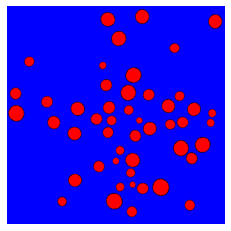

Image flipping completed. Modified image saved as /mnt/d/Research Projects/FEniCS/automation/flip images/circular_bimodal_distributioncircular_0.11 (1)_flipped.png


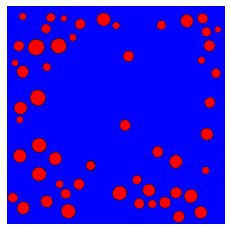

Image flipping completed. Modified image saved as /mnt/d/Research Projects/FEniCS/automation/flip images/circular_bimodal_distributioncircular_0.3_4 (1)_flipped.png


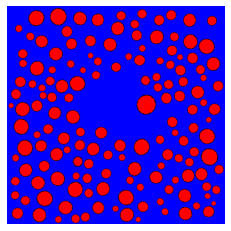

In [8]:
import os
import glob
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

def convert_colors(image_path, output_folder):
    # Load the image
    image = Image.open(image_path)
    image = image.convert("RGB")  # Convert image to RGB mode

    # Flip the modified image vertically
    modified_image = ImageOps.flip(image)

    # Get the file name and extension
    file_name, extension = os.path.splitext(os.path.basename(image_path))

    # Specify the output file path
    new_image_path = os.path.join(output_folder, file_name + "_flipped" + extension)

    # Save the modified image
    modified_image.save(new_image_path)

    print("Image flipping completed. Modified image saved as", new_image_path)

    # Display the modified image
    plt.imshow(modified_image)
    plt.axis('off')
    plt.show()

def flip_images_in_folder(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of image file paths in the input folder
    image_paths = glob.glob(os.path.join(input_folder, "*.jpg")) + glob.glob(os.path.join(input_folder, "*.png"))

    # Flip and save each image
    for image_path in image_paths:
        convert_colors(image_path, output_folder)

# Specify the input and output folder paths
input_folder = "/mnt/d/Research Projects/FEniCS/automation/images used to make flip images"  # Specify the path to the input folder containing the images
output_folder = "/mnt/d/Research Projects/FEniCS/automation/flip images"  # Specify the path to the output folder to save the flipped images

# Flip images in the input folder and save them in the output folder
flip_images_in_folder(input_folder, output_folder)


## msh file -> dat file (dat file containing cell midpoints)

In [9]:
import os
import glob
import meshio
import numpy as np

def convert_msh_to_dat(msh_file, dat_file):
    # Read the mesh file
    mesh = meshio.read(msh_file)

    # Get the cell midpoints
    cell_midpoints = []
    for cell_block in mesh.cells:
        cell_type = cell_block.type
        cell_data = cell_block.data
        if cell_type == "triangle":
            for cell_vertices in cell_data:
                # Calculate the midpoint of the cell
                midpoint = np.mean(mesh.points[cell_vertices], axis=0)
                cell_midpoints.append(midpoint)

    # Convert the cell midpoints to a numpy array
    cell_midpoints = np.array(cell_midpoints)

    # Save the cell midpoints to the .dat file
    np.savetxt(dat_file, cell_midpoints, fmt="%.6f")

def convert_msh_files_in_folder(input_folder, output_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # Get a list of .msh file paths in the input folder
    msh_files = glob.glob(os.path.join(input_folder, "*.msh"))

    # Convert each .msh file to .dat
    for msh_file in msh_files:
        # Get the base name of the .msh file without extension
        file_name = os.path.splitext(os.path.basename(msh_file))[0]

        # Specify the corresponding .dat file path
        dat_file = os.path.join(output_folder, file_name + ".dat")

        # Convert .msh to .dat
        convert_msh_to_dat(msh_file, dat_file)

# Specify the input folder and output folder paths
input_folder = "/mnt/d/Research Projects/FEniCS/automation/msh files"  # Specify the path to the input folder containing the .msh files
output_folder = "/mnt/d/Research Projects/FEniCS/automation/dat"  # Specify the path to the output folder to save the .dat files

# Convert .msh files in the input folder and save them in the output folder
convert_msh_files_in_folder(input_folder, output_folder)


## store material property from image to dat file as 4th column

In [10]:
import os
import glob
import numpy as np
import meshio
import imageio

def convert_image_to_dat(image_file, msh_file, dat_file):
    # Load the image
    image = imageio.v2.imread(image_file)

    # Load the mesh from .msh file
    mesh = meshio.read(msh_file)

    # Get the cell midpoints
    cell_midpoints = []
    for cell_block in mesh.cells:
        cell_type = cell_block.type
        cell_data = cell_block.data
        if cell_type == "triangle":
            for cell_vertices in cell_data:
                # Calculate the midpoint of the cell
                midpoint = np.mean(mesh.points[cell_vertices], axis=0)
                cell_midpoints.append(midpoint)

    # Convert the image to .dat
    with open(dat_file, "w") as file:
        for midpoint in cell_midpoints:
            # Determine the color of the cell
            x_index = np.clip(int(midpoint[0]), 0, image.shape[1] - 1)
            y_index = np.clip(int(midpoint[1]), 0, image.shape[0] - 1)
            color = image[y_index, x_index][:3]

            # Determine the fourth column value based on color
            fourth_column = 1 if color[0] >= 127.5 else 0

            # Write the XYZ coordinates and fourth column value to the .dat file
            file.write(f"{midpoint[0]} {midpoint[1]} {midpoint[2]} {fourth_column}\n")


def convert_files_in_folders(msh_folder, image_folder, dat_folder):
    # Create the output folder if it doesn't exist
    os.makedirs(dat_folder, exist_ok=True)

    # Get a list of file paths in the respective input folders
    msh_files = glob.glob(os.path.join(msh_folder, "*.msh"))
    image_files = glob.glob(os.path.join(image_folder, "*.jpg")) + glob.glob(os.path.join(image_folder, "*.png"))
    dat_files = glob.glob(os.path.join(dat_folder, "*.dat"))

    # Sort the file paths in alphabetical order
    msh_files.sort()
    image_files.sort()
    dat_files.sort()

    # Iterate over the files and convert them
    for msh_file, image_file, dat_file in zip(msh_files, image_files, dat_files):
        convert_image_to_dat(image_file, msh_file, dat_file)


# Specify the input folders and output folder paths
msh_folder = "/mnt/d/Research Projects/FEniCS/automation/msh files"  # Path to the folder containing the .msh files
image_folder = "/mnt/d/Research Projects/FEniCS/automation/flip images"  # Path to the folder containing the images
dat_folder = "/mnt/d/Research Projects/FEniCS/automation/dat"  # Path to the folder to save the .dat files

# Convert the files in the folders
convert_files_in_folders(msh_folder, image_folder, dat_folder)


## import msh file in fenics by converting it to xdmf file and reading mesh from it

In [23]:
import meshio
mesh_from_file = meshio.read("/mnt/d/Research Projects/FEniCS/automation/msh files/1.msh")

import numpy
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})
    return out_mesh

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("/mnt/d/Research Projects/FEniCS/automation/mat_xdmf/1.xdmf", triangle_mesh)

from dolfin import * 
mesh = Mesh()
with XDMFFile("/mnt/d/Research Projects/FEniCS/automation/mat_xdmf/1.xdmf") as infile:
    infile.read(mesh)

## read 4th column material property data from dat file and update xdmf file

In [24]:
def extract_fourth_column(dat_file):
    fourth_column = []
    with open(dat_file, "r") as file:
        for line in file:
            elements = line.strip().split()
            fourth_column.append(int(elements[3]))  # Assuming the fourth column is at index 3
    return fourth_column

# Provide the path to the DAT file
dat_file = "/mnt/d/Research Projects/FEniCS/automation/dat/1.dat"

# Extract the fourth column elements
fourth_column_array = extract_fourth_column(dat_file)
fourth_column_array

import dolfin

materials = MeshFunction('double', mesh, 2)

V = VectorFunctionSpace(mesh, "Lagrange", 2)
u = Function(V)

local_values_material = np.zeros_like(u.vector().get_local())

for cell in cells(mesh):
    midpoint = cell.midpoint().array()
    i = (midpoint[0])
    j = (midpoint[1])
    k = (midpoint[2])
    local_values_material[cell.index()] = fourth_column_array[cell.index()]
    materials[cell] = int(local_values_material[cell.index()])
    print(midpoint, i, j , k, "Material:", materials[cell], "Cell index: ", cell.index())
    
u.vector().set_local(local_values_material)

dolfin.XDMFFile(dolfin.MPI.comm_world, "/mnt/d/Research Projects/FEniCS/automation/mat_xdmf/1.xdmf").write_checkpoint(u,"u",0)

[569.05971699 704.32769999   0.        ] 569.0597169868594 704.3276999916164 0.0 Material: 1.0 Cell index:  0
[466.15603768 602.56267864   0.        ] 466.15603767991706 602.5626786362001 0.0 Material: 1.0 Cell index:  1
[718.81140595 855.59412943   0.        ] 718.8114059466983 855.5941294346563 0.0 Material: 1.0 Cell index:  2
[464.62930535 493.17286315   0.        ] 464.6293053453182 493.17286315479714 0.0 Material: 1.0 Cell index:  3
[704.54274325 827.39255417   0.        ] 704.5427432518145 827.3925541676435 0.0 Material: 1.0 Cell index:  4
[ 33.30986666 388.79263998   0.        ] 33.30986665899187 388.7926399785181 0.0 Material: 1.0 Cell index:  5
[902.2257353 508.6154806   0.       ] 902.2257352968332 508.61548059946404 0.0 Material: 0.0 Cell index:  6
[963.3308634  488.94136227   0.        ] 963.3308634026627 488.941362274531 0.0 Material: 1.0 Cell index:  7
[451.68907371 289.08525354   0.        ] 451.6890737149922 289.0852535427909 0.0 Material: 1.0 Cell index:  8
[314.065241

[  5.61435257 836.30149173   0.        ] 5.614352574830572 836.3014917333579 0.0 Material: 0.0 Cell index:  3101
[186.69850827   5.61435257   0.        ] 186.69850826637852 5.614352574784038 0.0 Material: 0.0 Cell index:  3102
[643.79283899 866.29035895   0.        ] 643.7928389947239 866.2903589511316 0.0 Material: 1.0 Cell index:  3103
[743.2169677  485.89464788   0.        ] 743.2169676996967 485.89464787843957 0.0 Material: 1.0 Cell index:  3104
[938.55337088 671.65225181   0.        ] 938.5533708832858 671.6522518115197 0.0 Material: 1.0 Cell index:  3105
[337.52005952 607.19597248   0.        ] 337.5200595206747 607.1959724818252 0.0 Material: 1.0 Cell index:  3106
[464.01345332 603.83560032   0.        ] 464.0134533156408 603.8356003244909 0.0 Material: 1.0 Cell index:  3107
[282.75001102 811.41355284   0.        ] 282.75001101562424 811.4135528377707 0.0 Material: 0.0 Cell index:  3108
[606.45514744 352.19184419   0.        ] 606.4551474362389 352.1918441918104 0.0 Material: 1.

[572.4096113  964.75826316   0.        ] 572.4096112972759 964.7582631568565 0.0 Material: 1.0 Cell index:  5601
[490.15809596 894.96825984   0.        ] 490.1580959552084 894.9682598355834 0.0 Material: 1.0 Cell index:  5602
[ 23.61395311 403.60100625   0.        ] 23.61395311443629 403.60100624847104 0.0 Material: 1.0 Cell index:  5603
[158.55532243 124.17505264   0.        ] 158.55532242985456 124.17505263591705 0.0 Material: 0.0 Cell index:  5604
[415.80105891 764.38516306   0.        ] 415.8010589100609 764.385163058144 0.0 Material: 1.0 Cell index:  5605
[300.94847102 829.15241832   0.        ] 300.9484710211139 829.1524183211072 0.0 Material: 1.0 Cell index:  5606
[ 34.14902089 506.69600295   0.        ] 34.149020891595214 506.69600295258005 0.0 Material: 1.0 Cell index:  5607
[991.75676271  79.19818627   0.        ] 991.7567627134227 79.19818627108695 0.0 Material: 1.0 Cell index:  5608
[681.97314429 561.40231621   0.        ] 681.9731442892161 561.4023162133649 0.0 Material: 1

[472.363541    83.20172657   0.        ] 472.363540996397 83.20172656555025 0.0 Material: 1.0 Cell index:  7900
[473.08046623  82.37837179   0.        ] 473.08046622568764 82.37837178557992 0.0 Material: 1.0 Cell index:  7901
[892.35646397 495.2658764    0.        ] 892.3564639724383 495.2658764025171 0.0 Material: 1.0 Cell index:  7902
[572.52359585 795.96895635   0.        ] 572.5235958509967 795.9689563483881 0.0 Material: 1.0 Cell index:  7903
[829.4921158  576.23596416   0.        ] 829.4921158020406 576.2359641559678 0.0 Material: 0.0 Cell index:  7904
[ 56.3455712  406.88312713   0.        ] 56.34557119567605 406.8831271339555 0.0 Material: 1.0 Cell index:  7905
[ 55.54152007 406.22196099   0.        ] 55.541520072464614 406.22196098663375 0.0 Material: 1.0 Cell index:  7906
[311.30294661 622.27601476   0.        ] 311.30294660853235 622.2760147628475 0.0 Material: 1.0 Cell index:  7907
[416.22191235 518.160367     0.        ] 416.2219123492915 518.160366997812 0.0 Material: 1.0

[198.21902717 972.08968379   0.        ] 198.2190271687859 972.0896837937444 0.0 Material: 0.0 Cell index:  10281
[194.33374455 975.93830869   0.        ] 194.33374454676144 975.9383086921194 0.0 Material: 0.0 Cell index:  10282
[261.02359792 929.40862319   0.        ] 261.0235979152496 929.408623188045 0.0 Material: 1.0 Cell index:  10283
[517.14505441 422.31879099   0.        ] 517.1450544123295 422.31879099262824 0.0 Material: 0.0 Cell index:  10284
[452.13460399 388.03816677   0.        ] 452.13460399253194 388.0381667732725 0.0 Material: 1.0 Cell index:  10285
[888.07555273 641.36234371   0.        ] 888.0755527306495 641.3623437054204 0.0 Material: 1.0 Cell index:  10286
[891.75059907 833.61740927   0.        ] 891.7505990679705 833.6174092737128 0.0 Material: 0.0 Cell index:  10287
[ 45.04762026 394.24246868   0.        ] 45.04762026029356 394.24246867636793 0.0 Material: 1.0 Cell index:  10288
[316.68425782 489.15863265   0.        ] 316.68425782157834 489.1586326506924 0.0 Mat

[171.03411855 459.99302011   0.        ] 171.03411854789013 459.993020108464 0.0 Material: 1.0 Cell index:  12282
[490.71718559  83.24420493   0.        ] 490.7171855934327 83.24420492738602 0.0 Material: 1.0 Cell index:  12283
[920.35091693 578.64339967   0.        ] 920.3509169250532 578.6433996744059 0.0 Material: 0.0 Cell index:  12284
[930.47617455 624.724966     0.        ] 930.4761745538589 624.7249660024369 0.0 Material: 1.0 Cell index:  12285
[529.99915397 689.57474053   0.        ] 529.9991539654211 689.5747405284252 0.0 Material: 1.0 Cell index:  12286
[940.39563339 652.32847611   0.        ] 940.3956333904672 652.328476112646 0.0 Material: 1.0 Cell index:  12287
[ 66.23840886 637.90750363   0.        ] 66.23840885599503 637.9075036266909 0.0 Material: 0.0 Cell index:  12288
[599.47820706 342.02173076   0.        ] 599.4782070645668 342.0217307642002 0.0 Material: 1.0 Cell index:  12289
[497.51009296 935.33260724   0.        ] 497.510092963076 935.3326072366227 0.0 Material:

[778.12508068 186.63825666   0.        ] 778.1250806808508 186.63825665563652 0.0 Material: 1.0 Cell index:  14657
[  3.20731786 690.21519272   0.        ] 3.207317858911784 690.2151927233084 0.0 Material: 0.0 Cell index:  14658
[332.80849718   3.18206021   0.        ] 332.80849718288727 3.182060210463172 0.0 Material: 0.0 Cell index:  14659
[443.45298304 982.59317943   0.        ] 443.4529830401071 982.5931794278173 0.0 Material: 0.0 Cell index:  14660
[745.45348723 858.72981985   0.        ] 745.4534872304697 858.7298198510149 0.0 Material: 1.0 Cell index:  14661
[744.54482352 857.86722223   0.        ] 744.5448235229032 857.8672222310912 0.0 Material: 1.0 Cell index:  14662
[ 53.13034291 669.74237387   0.        ] 53.13034290567867 669.7423738677829 0.0 Material: 0.0 Cell index:  14663
[352.66033955  53.39097554   0.        ] 352.6603395504842 53.390975544122504 0.0 Material: 0.0 Cell index:  14664
[676.80846455 585.88370106   0.        ] 676.8084645549055 585.8837010636445 0.0 Mate

[795.37675745 661.64140952   0.        ] 795.376757447938 661.6414095159511 0.0 Material: 1.0 Cell index:  17352
[337.13537728 602.67728767   0.        ] 337.1353772754856 602.6772876749402 0.0 Material: 1.0 Cell index:  17353
[907.2167614  644.98745266   0.        ] 907.2167614026422 644.987452655038 0.0 Material: 1.0 Cell index:  17354
[906.17631258 645.28664333   0.        ] 906.1763125830549 645.2866433321029 0.0 Material: 1.0 Cell index:  17355
[ 84.76637602 282.91003893   0.        ] 84.76637602432517 282.910038933808 0.0 Material: 0.0 Cell index:  17356
[492.43690814  48.91699206   0.        ] 492.43690814290204 48.9169920636823 0.0 Material: 1.0 Cell index:  17357
[933.48264668  17.74686864   0.        ] 933.4826466833096 17.746868643919317 0.0 Material: 0.0 Cell index:  17358
[384.600848   423.28997407   0.        ] 384.60084800402956 423.28997406721055 0.0 Material: 0.0 Cell index:  17359
[497.38664207 151.09554693   0.        ] 497.3866420729516 151.09554692551762 0.0 Materi

[ 37.35712748 527.30493295   0.        ] 37.35712748070173 527.3049329466185 0.0 Material: 1.0 Cell index:  20128
[893.425437   957.74974812   0.        ] 893.4254370005505 957.7497481236609 0.0 Material: 0.0 Cell index:  20129
[463.47911277 390.91875733   0.        ] 463.47911276816654 390.91875733412775 0.0 Material: 1.0 Cell index:  20130
[475.02425543 380.72107378   0.        ] 475.0242554274059 380.7210737844716 0.0 Material: 1.0 Cell index:  20131
[747.69267348 490.10183479   0.        ] 747.6926734833751 490.10183479229755 0.0 Material: 1.0 Cell index:  20132
[762.53995216 766.08365601   0.        ] 762.5399521622375 766.0836560096835 0.0 Material: 0.0 Cell index:  20133
[388.28438903 472.91338748   0.        ] 388.28438903196997 472.9133874798703 0.0 Material: 0.0 Cell index:  20134
[601.57310704 601.40325032   0.        ] 601.5731070382349 601.4032503201429 0.0 Material: 1.0 Cell index:  20135
[713.80283106 841.43096633   0.        ] 713.8028310587874 841.4309663347153 0.0 Mat

[462.78586509 577.47542033   0.        ] 462.78586509121834 577.4754203251051 0.0 Material: 1.0 Cell index:  22758
[543.08102853 421.47116385   0.        ] 543.0810285275812 421.4711638496399 0.0 Material: 1.0 Cell index:  22759
[519.34205327  74.38623859   0.        ] 519.3420532705449 74.38623858621484 0.0 Material: 0.0 Cell index:  22760
[519.15010719  69.80546954   0.        ] 519.1501071875886 69.80546953713763 0.0 Material: 0.0 Cell index:  22761
[867.29105348 715.21751779   0.        ] 867.2910534788566 715.217517785204 0.0 Material: 1.0 Cell index:  22762
[307.2841365  107.51542616   0.        ] 307.28413649514977 107.51542616056598 0.0 Material: 0.0 Cell index:  22763
[951.32290676 583.14817506   0.        ] 951.3229067581947 583.1481750590814 0.0 Material: 0.0 Cell index:  22764
[455.92029795 276.16736404   0.        ] 455.92029794957006 276.1673640384888 0.0 Material: 1.0 Cell index:  22765
[577.56479215 415.44648963   0.        ] 577.5647921526519 415.4464896269631 0.0 Mate

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[790.63793327 768.89673904   0.        ] 790.637933273265 768.8967390400707 0.0 Material: 0.0 Cell index:  41852
[941.02288918  82.25449478   0.        ] 941.0228891774583 82.25449477684009 0.0 Material: 0.0 Cell index:  41853
[936.77783607  80.27996297   0.        ] 936.7778360723554 80.27996296622858 0.0 Material: 0.0 Cell index:  41854
[795.42473822 860.59260637   0.        ] 795.424738223905 860.592606372336 0.0 Material: 0.0 Cell index:  41855
[ 55.95162228 415.57139689   0.        ] 55.95162228272027 415.57139688686567 0.0 Material: 1.0 Cell index:  41856
[ 47.7137388  426.55337657   0.        ] 47.71373879680735 426.55337656766005 0.0 Material: 1.0 Cell index:  41857
[375.15910859 866.11779036   0.        ] 375.15910859323134 866.1177903555312 0.0 Material: 0.0 Cell index:  41858
[15.69321004 48.34828356  0.        ] 15.693210042338228 48.348283555480776 0.0 Material: 0.0 Cell index:  41859
[  48.34817626 1007.30586114    0.        ] 48.348176260744765 1007.3058611380087 0.0 Mat

[297.87827005 589.09822144   0.        ] 297.8782700457718 589.0982214435966 0.0 Material: 1.0 Cell index:  44489
[780.241176   198.84167981   0.        ] 780.2411759986167 198.84167981331203 0.0 Material: 1.0 Cell index:  44490
[254.95386841 825.70847439   0.        ] 254.9538684130981 825.7084743914542 0.0 Material: 0.0 Cell index:  44491
[786.24068398 629.07091338   0.        ] 786.2406839814948 629.0709133844379 0.0 Material: 0.0 Cell index:  44492
[534.03877346 676.3216294    0.        ] 534.0387734581994 676.3216294026141 0.0 Material: 1.0 Cell index:  44493
[558.68050322 617.87757128   0.        ] 558.6805032197931 617.8775712812618 0.0 Material: 0.0 Cell index:  44494
[936.25655758 639.84489198   0.        ] 936.2565575844541 639.8448919836081 0.0 Material: 1.0 Cell index:  44495
[821.16991753 696.50218031   0.        ] 821.1699175298705 696.5021803083233 0.0 Material: 1.0 Cell index:  44496
[889.79324717 462.12295588   0.        ] 889.7932471694743 462.12295587779903 0.0 Mater

[154.48579684 690.67660442   0.        ] 154.48579684070774 690.6766044160399 0.0 Material: 0.0 Cell index:  45541
[758.27127647 560.38509963   0.        ] 758.2712764712674 560.3850996324386 0.0 Material: 1.0 Cell index:  45542
[725.67453316 832.35132112   0.        ] 725.6745331550142 832.3513211224039 0.0 Material: 1.0 Cell index:  45543
[528.39412296 168.02171234   0.        ] 528.394122956004 168.0217123407956 0.0 Material: 1.0 Cell index:  45544
[467.22994689 846.44149088   0.        ] 467.2299468884628 846.4414908808222 0.0 Material: 0.0 Cell index:  45545
[565.67791384 738.60873472   0.        ] 565.6779138443272 738.6087347220874 0.0 Material: 1.0 Cell index:  45546
[658.49460714 564.48322566   0.        ] 658.4946071419669 564.4832256614183 0.0 Material: 1.0 Cell index:  45547
[533.62692639 159.82328668   0.        ] 533.6269263857743 159.82328667877786 0.0 Material: 1.0 Cell index:  45548
[745.06048325 552.94167754   0.        ] 745.0604832457892 552.9416775426034 0.0 Materi

[1017.2753588   282.98090442    0.        ] 1017.2753587954736 282.9809044200042 0.0 Material: 0.0 Cell index:  47386
[697.18290151 576.12675832   0.        ] 697.182901511389 576.1267583171131 0.0 Material: 1.0 Cell index:  47387
[511.40597772   2.24917746   0.        ] 511.40597771726743 2.2491774636181985 0.0 Material: 0.0 Cell index:  47388
[493.64851335 528.45677581   0.        ] 493.6485133521171 528.4567758056542 0.0 Material: 1.0 Cell index:  47389
[864.3031673 519.163204    0.       ] 864.30316729696 519.1632039986414 0.0 Material: 0.0 Cell index:  47390
[466.12586672 495.2137315    0.        ] 466.12586671629225 495.21373149609735 0.0 Material: 1.0 Cell index:  47391
[692.19686914 565.29594749   0.        ] 692.1968691434946 565.2959474926288 0.0 Material: 1.0 Cell index:  47392
[326.11276822 505.90418332   0.        ] 326.1127682189526 505.90418332197254 0.0 Material: 1.0 Cell index:  47393
[327.06342346 505.69337735   0.        ] 327.0634234558194 505.6933773458074 0.0 Mate

[543.55627809 592.23263486   0.        ] 543.5562780892133 592.2326348618907 0.0 Material: 0.0 Cell index:  49112
[ 42.33345362 400.08996088   0.        ] 42.333453615162114 400.08996088380724 0.0 Material: 1.0 Cell index:  49113
[648.75329117 846.14145645   0.        ] 648.75329117483 846.1414564522738 0.0 Material: 1.0 Cell index:  49114
[291.72543137 966.91001196   0.        ] 291.72543137339255 966.9100119615058 0.0 Material: 0.0 Cell index:  49115
[1009.75031944  201.21632606    0.        ] 1009.7503194395413 201.21632606291112 0.0 Material: 0.0 Cell index:  49116
[748.30345628 863.64662107   0.        ] 748.3034562838088 863.6466210653322 0.0 Material: 1.0 Cell index:  49117
[946.83673353 480.05843253   0.        ] 946.8367335346799 480.05843253226413 0.0 Material: 0.0 Cell index:  49118
[927.65196212  49.15598598   0.        ] 927.6519621225283 49.15598598102226 0.0 Material: 0.0 Cell index:  49119
[772.26771033 566.94370863   0.        ] 772.2677103343436 566.943708633081 0.0 M

[628.20170877 909.3906829    0.        ] 628.2017087671778 909.3906829012676 0.0 Material: 0.0 Cell index:  51638
[596.87657875 319.20797493   0.        ] 596.8765787474421 319.20797493009263 0.0 Material: 1.0 Cell index:  51639
[455.37001579 168.66346774   0.        ] 455.37001579089457 168.6634677445295 0.0 Material: 0.0 Cell index:  51640
[101.53387961 402.1197627    0.        ] 101.53387960900879 402.11976270440704 0.0 Material: 0.0 Cell index:  51641
[896.7383107  633.41507404   0.        ] 896.7383107016082 633.4150740422491 0.0 Material: 1.0 Cell index:  51642
[187.33896667 783.73021179   0.        ] 187.3389666718106 783.7302117908251 0.0 Material: 0.0 Cell index:  51643
[239.21449738 187.30059631   0.        ] 239.21449738012439 187.3005963096294 0.0 Material: 0.0 Cell index:  51644
[412.70821295 522.64776943   0.        ] 412.7082129482787 522.6477694276621 0.0 Material: 1.0 Cell index:  51645
[406.273697   543.92331655   0.        ] 406.2736970027469 543.9233165524766 0.0 Ma

[575.75468409 423.13729996   0.        ] 575.7546840900094 423.13729996029434 0.0 Material: 1.0 Cell index:  53054
[576.38692741 423.86854129   0.        ] 576.386927408023 423.8685412906204 0.0 Material: 1.0 Cell index:  53055
[874.06836426 944.25847994   0.        ] 874.0683642575706 944.2584799437545 0.0 Material: 1.0 Cell index:  53056
[873.10431128 944.42437329   0.        ] 873.1043112794264 944.4243732907366 0.0 Material: 1.0 Cell index:  53057
[334.27975629 796.65606515   0.        ] 334.2797562895398 796.6560651452401 0.0 Material: 1.0 Cell index:  53058
[532.5199916  584.00812786   0.        ] 532.5199915956755 584.0081278625389 0.0 Material: 0.0 Cell index:  53059
[168.20097215  58.7635788    0.        ] 168.2009721489146 58.76357879558166 0.0 Material: 0.0 Cell index:  53060
[900.90201979 533.50377732   0.        ] 900.9020197867234 533.5037773201831 0.0 Material: 0.0 Cell index:  53061
[572.47971715 429.20897881   0.        ] 572.4797171457808 429.2089788062667 0.0 Materia

[510.08316174 906.44047114   0.        ] 510.0831617353837 906.4404711358508 0.0 Material: 1.0 Cell index:  55400
[532.3150528  862.25041538   0.        ] 532.3150527950414 862.25041538332 0.0 Material: 1.0 Cell index:  55401
[532.39346499 860.60861092   0.        ] 532.3934649885161 860.608610921509 0.0 Material: 1.0 Cell index:  55402
[618.49670625  38.58715643   0.        ] 618.4967062462182 38.58715643394479 0.0 Material: 1.0 Cell index:  55403
[325.77117028 584.6439785    0.        ] 325.7711702817503 584.6439785034994 0.0 Material: 1.0 Cell index:  55404
[582.39414494 611.24421515   0.        ] 582.3941449449616 611.2442151487038 0.0 Material: 1.0 Cell index:  55405
[873.87226684 499.35409137   0.        ] 873.872266844663 499.35409136619825 0.0 Material: 1.0 Cell index:  55406
[465.84354871 467.67775998   0.        ] 465.843548708677 467.6777599796582 0.0 Material: 1.0 Cell index:  55407
[926.99910283 626.20345735   0.        ] 926.9991028307873 626.2034573518204 0.0 Material: 1

[449.33573877 354.27551711   0.        ] 449.3357387701714 354.27551711081486 0.0 Material: 1.0 Cell index:  58091
[809.66304858 311.17182293   0.        ] 809.6630485799188 311.1718229297655 0.0 Material: 0.0 Cell index:  58092
[374.06317116 102.13094829   0.        ] 374.06317116259896 102.13094828600033 0.0 Material: 0.0 Cell index:  58093
[862.55369398 471.47482589   0.        ] 862.5536939830932 471.47482589080977 0.0 Material: 1.0 Cell index:  58094
[722.5997491    5.29954449   0.        ] 722.5997491026383 5.299544486976187 0.0 Material: 0.0 Cell index:  58095
[972.64633842  91.48201655   0.        ] 972.646338423648 91.482016550388 0.0 Material: 1.0 Cell index:  58096
[589.77760386 392.98890753   0.        ] 589.7776038556258 392.98890752888184 0.0 Material: 1.0 Cell index:  58097
[657.10658198 400.83727057   0.        ] 657.106581977367 400.8372705681404 0.0 Material: 1.0 Cell index:  58098
[289.84816851 685.81156545   0.        ] 289.8481685050493 685.8115654549956 0.0 Materi

[932.89496991 837.93675504   0.        ] 932.8949699104425 837.9367550411225 0.0 Material: 0.0 Cell index:  60552
[239.88318582 553.85565089   0.        ] 239.8831858187876 553.8556508865362 0.0 Material: 1.0 Cell index:  60553
[520.2434779  144.69775636   0.        ] 520.2434779034658 144.69775635897807 0.0 Material: 1.0 Cell index:  60554
[840.6582847  951.10180933   0.        ] 840.65828469612 951.1018093328465 0.0 Material: 0.0 Cell index:  60555
[429.02177846 149.89311731   0.        ] 429.02177845999904 149.89311730869522 0.0 Material: 0.0 Cell index:  60556
[489.55116873 685.41924184   0.        ] 489.5511687344104 685.4192418392214 0.0 Material: 0.0 Cell index:  60557
[941.36049234 633.70120789   0.        ] 941.3604923443708 633.7012078924249 0.0 Material: 1.0 Cell index:  60558
[614.59119334 871.93224783   0.        ] 614.5911933414153 871.932247832944 0.0 Material: 0.0 Cell index:  60559
[693.51697864 415.51947587   0.        ] 693.5169786407529 415.5194758683258 0.0 Materia

[795.39967223 423.8036332    0.        ] 795.3996722319702 423.80363319931485 0.0 Material: 1.0 Cell index:  63299
[796.26839056 423.37457418   0.        ] 796.2683905636022 423.37457417800914 0.0 Material: 1.0 Cell index:  63300
[673.1538616  204.84399601   0.        ] 673.1538615981682 204.84399600992057 0.0 Material: 0.0 Cell index:  63301
[896.84812059 620.34504047   0.        ] 896.8481205892436 620.3450404684991 0.0 Material: 0.0 Cell index:  63302
[417.40323548 767.04230797   0.        ] 417.4032354751184 767.0423079682392 0.0 Material: 1.0 Cell index:  63303
[844.2519947  669.76638769   0.        ] 844.2519946957082 669.7663876892701 0.0 Material: 1.0 Cell index:  63304
[ 57.54510888 819.06280539   0.        ] 57.545108883104355 819.0628053857945 0.0 Material: 0.0 Cell index:  63305
[994.01786902 991.09646608   0.        ] 994.0178690172003 991.0964660795959 0.0 Material: 0.0 Cell index:  63306
[340.69427408 498.07334661   0.        ] 340.69427407985944 498.0733466056979 0.0 Ma

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



76.99990344845793 0.0 Material: 1.0 Cell index:  82949
[655.65619252  67.42390066   0.        ] 655.6561925166785 67.42390065539723 0.0 Material: 1.0 Cell index:  82950
[594.47752822 422.93982833   0.        ] 594.4775282196579 422.9398283348378 0.0 Material: 1.0 Cell index:  82951
[596.72081191 420.29112396   0.        ] 596.7208119075713 420.2911239633661 0.0 Material: 1.0 Cell index:  82952
[783.40298369 469.02755447   0.        ] 783.4029836906781 469.0275544726233 0.0 Material: 1.0 Cell index:  82953
[782.42890428 465.9008553    0.        ] 782.428904277201 465.9008552966431 0.0 Material: 1.0 Cell index:  82954
[299.1932788  805.06754312   0.        ] 299.1932787993778 805.0675431220925 0.0 Material: 1.0 Cell index:  82955
[300.63950223 799.75983015   0.        ] 300.63950222717204 799.7598301478041 0.0 Material: 1.0 Cell index:  82956
[299.00706655 803.6082911    0.        ] 299.0070665457867 803.6082911014761 0.0 Material: 1.0 Cell index:  82957
[300.63505886 801.34875921   0.  

## user-defined function to assign different material properties

In [25]:
class al(UserExpression):
    def __init__(self, materials, al0, al1, **kwargs):
        super().__init__(**kwargs)
        self.materials = materials
        self.k_0 = al0
        self.k_1 = al1
    def eval_cell(self, values, x, cell):
        if self.materials[cell.index] == 0:
            values[0] = self.k_0
        else:
            values[0] = self.k_1
            
#(matrix) = AL            
E1 = 62e3 
nu1 = 0.32
#(inclusion) = SiC
E2 = 450e3 
nu2 = 0.35

E = al(materials, E1, E2, degree = 0)
nu = al(materials, nu1, nu2, degree = 0)

File('/mnt/d/Research Projects/FEniCS/automation/E/E1.pvd') << project(E, FunctionSpace(mesh, 'DG', 0))
File('/mnt/d/Research Projects/FEniCS/automation/nu/nu1.pvd') << project(nu, FunctionSpace(mesh, 'DG', 0))
File('/mnt/d/Research Projects/FEniCS/automation/materials/mat1.pvd') << materials

## Whole code to automate and save plots of displacment & stress (sigma[1, 1], sigma_yy)

In [6]:
import os
import meshio
from dolfin import *
import dolfin
import numpy as np
import matplotlib.pyplot as plt

def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    points = mesh.points[:, :2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})
    return out_mesh

def extract_fourth_column(dat_file):
    fourth_column = []
    with open(dat_file, "r") as file:
        for line in file:
            elements = line.strip().split()
            fourth_column.append(int(elements[3]))  # Assuming the fourth column is at index 3
    return fourth_column

# Provide the paths to the folders
msh_folder = "/mnt/d/Research Projects/FEniCS/automation/msh files"
xdmf_folder = "/mnt/d/Research Projects/FEniCS/automation/mat_xdmf"
dat_folder = "/mnt/d/Research Projects/FEniCS/automation/dat"
E_folder = "/mnt/d/Research Projects/FEniCS/automation/E"
nu_folder = "/mnt/d/Research Projects/FEniCS/automation/nu"
mat_folder = "/mnt/d/Research Projects/FEniCS/automation/materials"
displacement_folder = "/mnt/d/Research Projects/FEniCS/automation/displacement_plots"
stress_plots_folder = "/mnt/d/Research Projects/FEniCS/automation/stress_plots"
# stress_folder = "/mnt/d/Research Projects/FEniCS/automation/stress_xdmf"

# Get the list of files in the msh folder
msh_files = sorted(os.listdir(msh_folder))

# Process each file in the msh folder
for i, msh_file_name in enumerate(msh_files):
    # Step 1: Read the mesh file and create a triangle mesh
    msh_file_path = os.path.join(msh_folder, msh_file_name)
    mesh_from_file = meshio.read(msh_file_path)
    triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)

    # Step 2: Write the triangle mesh to an XDMF file
    xdmf_file_path = os.path.join(xdmf_folder, f"{i+1}.xdmf")
    meshio.write(xdmf_file_path, triangle_mesh)

    # Get the corresponding DAT file and XDMF file paths
    dat_file_name = f"{i+1}.dat"
    dat_file_path = os.path.join(dat_folder, dat_file_name)
    xdmf_file_path = os.path.join(xdmf_folder, f"{i+1}.xdmf")

    # Step 3: Extract the fourth column elements from the DAT file
    fourth_column_array = extract_fourth_column(dat_file_path)

    # Step 4: Create a Dolfin mesh object and read the XDMF file
    mesh = Mesh()
    with XDMFFile(xdmf_file_path) as infile:
        infile.read(mesh)

    # Step 5: Assign the values from the fourth column to the materials variable
    materials = MeshFunction('double', mesh, 2)

    # Step 6: Create a vector function space and a function object
    V = VectorFunctionSpace(mesh, "Lagrange", 2)
    u = Function(V)

    local_values_material = np.zeros_like(u.vector().get_local())

    # Step 7: Iterate over the mesh cells and assign values to the materials
    for cell in cells(mesh):
        midpoint = cell.midpoint().array()
        i = midpoint[0]
        j = midpoint[1]
        k = midpoint[2]
        local_values_material[cell.index()] = fourth_column_array[cell.index()]
        materials[cell] = int(local_values_material[cell.index()])

    # Step 8: Write the updated function to the XDMF file
    u.vector().set_local(local_values_material)
    dolfin.XDMFFile(dolfin.MPI.comm_world, xdmf_file_path).write_checkpoint(u, "u", 0)

    # Step 9: Define the al user expression class
    class al(UserExpression):
        def __init__(self, materials, al0, al1, **kwargs):
            super().__init__(**kwargs)
            self.materials = materials
            self.k_0 = al0
            self.k_1 = al1

        def eval_cell(self, values, x, cell):
            if self.materials[cell.index] == 0:
                values[0] = self.k_0
            else:
                values[0] = self.k_1

    # Step 10: Define the elastic properties E and nu based on the materials
    E1 = 62e3
    nu1 = 0.32
    E2 = 450e3
    nu2 = 0.35

    E = al(materials, E1, E2, degree=0)
    nu = al(materials, nu1, nu2, degree=0)

    # Step 11: Write E, nu, and materials functions to PVD files
    File(os.path.join(E_folder, f"E_{i+1}.pvd")) << project(E, FunctionSpace(mesh, 'DG', 0))
    File(os.path.join(nu_folder, f"nu_{i+1}.pvd")) << project(nu, FunctionSpace(mesh, 'DG', 0))
    File(os.path.join(mat_folder, f"materials_{i+1}.pvd")) << materials

    class bottom(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0.)

    class top(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 1023.)

    boundaries = MeshFunction("size_t", mesh, mesh.geometry().dim()-1)

    bottom().mark(boundaries, 1) 
    top().mark(boundaries, 2) 

    bcs = [DirichletBC(V, Constant((0., 0.)), boundaries, 1), DirichletBC(V.sub(1), Constant((-2)), boundaries, 2)]

    def eps(v):
        return sym(grad(v))

    def sigma(v):
        return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

    mu = E/2/(1+nu)
    lmbda = E*nu/(1+nu)/(1-2*nu)

    f = 0.
    f = Constant((0, f))

    du = TrialFunction(V)
    u_ = TestFunction(V)
    a = inner(sigma(du), eps(u_))*dx
    l = inner(f, u_)*dx

    u = Function(V, name="Displacement")
    solve(a == l, u, bcs)
    
    # Code for displacement plot
    plot(u, mode="displacement")
    plt.savefig(os.path.join(displacement_folder, f"displacement_{i+1}.png"))
    plt.close()

    # Code for stress plot
    stress = sigma(u)
    plot(stress[1, 1])
    plt.savefig(os.path.join(stress_plots_folder, f"stress_{i+1}.png"))
    plt.close()
    
#     Vsig = TensorFunctionSpace(mesh, "DG", degree=0)
#     sig = Function(Vsig, name="Stress")
#     sig.assign(project(sigma(u), Vsig))

#     file_results = XDMFFile(os.path.join(stress_folder, f"stress_{i+1}.xdmf"))
#     file_results.parameters["flush_output"] = True
#     file_results.parameters["functions_share_mesh"] = True
#     file_results.write(u, 0.)
#     file_results.write(sig, 0.)



Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.

Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.

Solving linear variational problem.
Object cannot be plotted directly, projecting to piecewise linears.


## test code with one msh, one dat and one xdmf file


Solving linear variational problem.


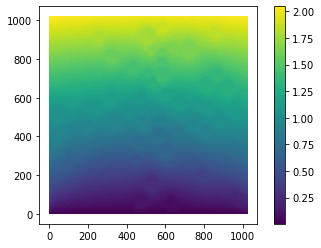

Object cannot be plotted directly, projecting to piecewise linears.


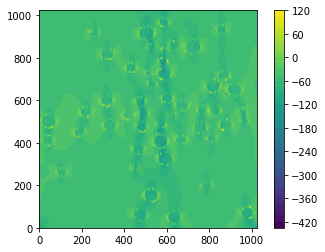

In [4]:
import meshio
mesh_from_file = meshio.read("/mnt/d/Research Projects/FEniCS/automation/msh files/1.msh")

import numpy
def create_mesh(mesh, cell_type, prune_z=False):
    cells = mesh.get_cells_type(cell_type)
    points = mesh.points[:,:2] if prune_z else mesh.points
    out_mesh = meshio.Mesh(points=points, cells={cell_type: cells})
    return out_mesh

triangle_mesh = create_mesh(mesh_from_file, "triangle", prune_z=True)
meshio.write("/mnt/d/Research Projects/FEniCS/automation/mat_xdmf/1.xdmf", triangle_mesh)

from dolfin import * 
mesh = Mesh()
with XDMFFile("/mnt/d/Research Projects/FEniCS/automation/mat_xdmf/1.xdmf") as infile:
    infile.read(mesh)

def extract_fourth_column(dat_file):
    fourth_column = []
    with open(dat_file, "r") as file:
        for line in file:
            elements = line.strip().split()
            fourth_column.append(int(elements[3]))  # Assuming the fourth column is at index 3
    return fourth_column

# Provide the path to the DAT file
dat_file = "/mnt/d/Research Projects/FEniCS/automation/dat/1.dat"

# Extract the fourth column elements
fourth_column_array = extract_fourth_column(dat_file)
fourth_column_array

import dolfin

materials = MeshFunction('double', mesh, 2)

V = VectorFunctionSpace(mesh, "Lagrange", 2)
u = Function(V)

local_values_material = np.zeros_like(u.vector().get_local())

for cell in cells(mesh):
    midpoint = cell.midpoint().array()
    i = (midpoint[0])
    j = (midpoint[1])
    k = (midpoint[2])
    local_values_material[cell.index()] = fourth_column_array[cell.index()]
    materials[cell] = int(local_values_material[cell.index()])
#     print(midpoint, i, j , k, "Material:", materials[cell], "Cell index: ", cell.index())
    
u.vector().set_local(local_values_material)

dolfin.XDMFFile(dolfin.MPI.comm_world, "/mnt/d/Research Projects/FEniCS/automation/mat_xdmf/1.xdmf").write_checkpoint(u,"u",0)

import dolfin as dol
class al(dol.UserExpression):
    def __init__(self, materials, al0, al1, **kwargs):
        super().__init__(**kwargs)
        self.materials = materials
        self.k_0 = al0
        self.k_1 = al1
    def eval_cell(self, values, x, cell):
        if self.materials[cell.index] == 0:
            values[0] = self.k_0
        else:
            values[0] = self.k_1
            
E1 = 21e3 #(matrix)
nu1 = 0.3
E2 = 2100e3 #(inclusion)
nu2 = 0.25

E = al(materials, E1, E2, degree = 0)
nu = al(materials, nu1, nu2, degree = 0)

class bottom(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 0.)

class top(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and near(x[1], 1023.)


boundaries = MeshFunction("size_t", mesh, mesh.geometry().dim()-1)

bottom().mark(boundaries, 1) 
top().mark(boundaries, 2) 

bcs = [DirichletBC(V, Constant((0., 0.)), boundaries, 1), DirichletBC(V.sub(1), Constant((-2)), boundaries, 2)]

def eps(v):
    return sym(grad(v))

def sigma(v):
    return lmbda*tr(eps(v))*Identity(2) + 2.0*mu*eps(v)

mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)

f = 0.
f = Constant((0, f))

du = TrialFunction(V)
u_ = TestFunction(V)
a = inner(sigma(du), eps(u_))*dx
l = inner(f, u_)*dx

u = Function(V, name="Displacement")
solve(a == l, u, bcs)

import matplotlib.pyplot as plt

# Code for displacement plot
k = plot(u, mode="displacement")
plt.colorbar(k)
plt.show()

# Code for stress plot
stress = sigma(u)
w = plot(stress[1, 1])
plt.colorbar(w)
plt.show()

# Vsig = TensorFunctionSpace(mesh, "DG", degree=0)
# sig = Function(Vsig, name="Stress")
# sig.assign(project(sigma(u), Vsig))

# file_results = XDMFFile("stress.xdmf")
# file_results.parameters["flush_output"] = True
# file_results.parameters["functions_share_mesh"] = True
# file_results.write(u, 0.)
# file_results.write(sig, 0.)